# Personal Information
Name: **Cinthya Criollo**

StudentID: **11977477**

Email: [**cinthya.criollo.quiroz@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **22.03.2024**

# Data Context
The dataset used for this Left Ventricle Image Segmentation thesis project is a fully annotated dataset of cardiac Ultrasound (US) images of the canine left ventricle (n = 16)  that was reused in this project. The 2-D B-mode US (434 x 636 pixels) images are sourced from previous studies. Animal handling procedures adhered to both the Dutch law on animal experimentation and the European directive concerning the protection of animals utilized for scientific purposes (Directive 2010/63/EU). The protocol received approval from the Animal Experimentation Committee of Maastricht University. In the case of US data, the collection was conducted using a GE Vivid5 ultrasound machine (manufactured by GE Vingmed Ultrasound, Norten, Norway). Specifically, a GE PA2-5 phased array transducer with a 3-MHz center frequency and a 75 opening angle, capturing at a rate of 90 frames per second, was employed to image the short axis of the left ventricle at the level of the papillary muscle (Awasthi, Vermeer, Fixsen, Lopata, & Pluim, 2022). 


# Data Description

In this section, I perform exploratory data analysis (EDA) on the dataset containing 1445, 475, and 342 images in Training, Test and Validation folders in Matlab format. The coordinates for the segmentation are found in the same folders. The code iterates over the MATLAB files, extracting inner and outer contours to create binary masks. The input images and the masks are resized and saved as PNG files for further analysis. Overall, this EDA process provides insights into the dataset's structure, content, and preprocessing requirements for working on the methodology.


In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import cv2
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import hdf5storage
from mat4py import savemat
from torch.utils.data import Dataset
from torchvision import transforms
import math
import itertools
from tqdm.auto import tqdm
import einops as E
import sys
import torch
import pathlib


### Data Loading
The directory path to the Training folder is set, and this code shows the lists the input and output files in the directory.

#### Path to all the Training Files

In [3]:
current_directory = os.getcwd()
remaining_path = 'Training'
input_folder = os.path.join(current_directory, remaining_path)

# Print the full path
print(input_folder)
os.chdir(input_folder)
#os.listdir()



C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\UniverSeg-main\UniverSeg-main\example_data\Training


#### Path to Load Training Input Images

The DataFrame to store input file paths related to training input images for left ventricle segmentation is created. The code sets up columns and dimensions for image resizing. It also ensures the existence of an output folder for storing resized images before processing.

In [4]:
# # Set the path to the directory where resized images will be saved
train_in = 'Training/train_input_png'
output_folder = os.path.join(current_directory, train_in )

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
os.chdir(output_folder)
os.listdir()
# # Ensure output folder exists


['Image00001.png',
 'Image00002.png',
 'Image00003.png',
 'Image00004.png',
 'Image00005.png',
 'Image00006.png',
 'Image00007.png',
 'Image00008.png',
 'Image00009.png',
 'Image00010.png',
 'Image00011.png',
 'Image00012.png',
 'Image00013.png',
 'Image00014.png',
 'Image00015.png',
 'Image00016.png',
 'Image00017.png',
 'Image00018.png',
 'Image00019.png',
 'Image00020.png',
 'Image00021.png',
 'Image00022.png',
 'Image00023.png',
 'Image00024.png',
 'Image00025.png',
 'Image00026.png',
 'Image00027.png',
 'Image00028.png',
 'Image00029.png',
 'Image00030.png',
 'Image00031.png',
 'Image00032.png',
 'Image00033.png',
 'Image00034.png',
 'Image00035.png',
 'Image00036.png',
 'Image00037.png',
 'Image00038.png',
 'Image00039.png',
 'Image00040.png',
 'Image00041.png',
 'Image00042.png',
 'Image00043.png',
 'Image00044.png',
 'Image00045.png',
 'Image00046.png',
 'Image00047.png',
 'Image00048.png',
 'Image00049.png',
 'Image00050.png',
 'Image00051.png',
 'Image00052.png',
 'Image00053

#### Path to Load Training Output Images 

The code initializes a DataFrame to store file paths related to training output masks. It sets up columns and dimensions for image resizing and ensures the existence of an output folder for storing resized masks before processing.

In [5]:
train_output_masks = 'Training/train_pap_png'
output_mask_folder = os.path.join(current_directory, train_output_masks )

# Ensure output folder exists
if not os.path.exists(output_mask_folder):
    os.makedirs(output_mask_folder)



In [6]:
# Set the path to the directory where resized images will be saved
nonpapoutput_png = 'Training/train_nonpapoutput_png'
nonpap_mask_folder = os.path.join(current_directory, nonpapoutput_png)
# Ensure output folder exists
if not os.path.exists(nonpap_mask_folder):
    os.makedirs(nonpap_mask_folder)


#### Path to Load Test Input Images

In [7]:
test = 'Test'
testinput = 'testinput'
test_input_path = os.path.join(current_directory, test)
if not os.path.exists(test_input_path):
    os.makedirs(test_input_path)

test_out_path = os.path.join(current_directory, testinput)
# Ensure output folder exists
if not os.path.exists(test_out_path):
    os.makedirs(test_out_path)

#### Path to load Test Output Images

In [8]:
# Set the path to the directory where resized images will be saved
test_output_png = 'test_pap_output_png'
test_pap_output_folder = os.path.join(current_directory, test_output_png)

# Ensure output folder exists
if not os.path.exists(test_pap_output_folder):
    os.makedirs(test_pap_output_folder)


In [9]:
# Set input and output folders
test_nonpap_output_png = 'test_nonpap_output_png'
test_nopap_output_folder = os.path.join(current_directory, test_nonpap_output_png)

# Ensure output folder exists
if not os.path.exists(test_nopap_output_folder):
    os.makedirs(test_nopap_output_folder)



### Analysis 1: Preprocess of training input images


**Image Resizing:** The code resizes an input image using OpenCV's cv2.resize() function, with a specified dimension and interpolation method (cv2.INTER_AREA).

**File Naming:** It generates a file name for the resized image based on the count of processed images. The format is 'Image' followed by a unique numeric identifier padded with leading zeros, and the file extension '.bmp'.

**Image Saving:** The resized image is saved as a BMP file in the designated output folder using cv2.imwrite().

This process facilitates the preprocessing of images, ensuring standardized dimensions and file naming conventions for further analysis or downstream tasks.

In [7]:
# Define the columns for the DataFrame
cols = ['Processed_Image_File']

# Initialize list to store file paths
file_paths = []

# Define image dimensions for resizing
width, height = 256, 256
dim = (width, height)
count = 1
# Iterate over each image file
for i in range(16):
    # Load the original image from MATLAB file
    file_load = os.path.join(input_folder, f'I{i+1}.mat')
    mat_file = sio.loadmat(file_load)
    image_data = mat_file['I']
    time_frame = image_data['tframe']
    reference_image = time_frame[0, 0]
    x_dim, y_dim = reference_image.shape

    # Iterate over each image in the original image set
    for j in range(y_dim):
        # Extract the image data
        image = reference_image[0, j]
        image_array = np.asarray(image[0])

        # Resize the image
        resized_image = cv2.resize(image_array, dim, interpolation=cv2.INTER_AREA)
        print(f'shape resized image {count:05}:',resized_image.shape)

        # Generate file name for the resized image
        file_save = os.path.join(output_folder, f'Image{count:05}.png')

        # Save the resized image
        cv2.imwrite(file_save, resized_image)

        # Add file path to the list
        file_paths.append(file_save)
        
        # Increment the count variable
        count += 1

# Create DataFrame from the list of file paths
df = pd.DataFrame({'Processed_Image_File': file_paths})

# Save the DataFrame as a CSV file
csv_output = os.path.join(input_folder, 'Processed_Images.csv')
df.to_csv(csv_output, index=False)


shape resized image 00001: (256, 256)
shape resized image 00002: (256, 256)
shape resized image 00003: (256, 256)
shape resized image 00004: (256, 256)
shape resized image 00005: (256, 256)
shape resized image 00006: (256, 256)
shape resized image 00007: (256, 256)
shape resized image 00008: (256, 256)
shape resized image 00009: (256, 256)
shape resized image 00010: (256, 256)
shape resized image 00011: (256, 256)
shape resized image 00012: (256, 256)
shape resized image 00013: (256, 256)
shape resized image 00014: (256, 256)
shape resized image 00015: (256, 256)
shape resized image 00016: (256, 256)
shape resized image 00017: (256, 256)
shape resized image 00018: (256, 256)
shape resized image 00019: (256, 256)
shape resized image 00020: (256, 256)
shape resized image 00021: (256, 256)
shape resized image 00022: (256, 256)
shape resized image 00023: (256, 256)
shape resized image 00024: (256, 256)
shape resized image 00025: (256, 256)
shape resized image 00026: (256, 256)
shape resize

In [17]:
import cv2

# Load an example image
image_path = "C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\UniverSeg-main\\UniverSeg-main\\example_data\\Training\train_input_png\\Image00020.png"
image = cv2.imread(image_path)

# Check the shape of the image array
print("Image shape:", image.shape)


AttributeError: 'NoneType' object has no attribute 'shape'

In [12]:
# # Define the columns for the DataFrame
# cols = ['Processed_Image_File']
# 
# # Initialize list to store file paths
# file_paths = []
# 
# # Define image dimensions for resizing
# width, height = 256, 256
# dim = (width, height)
# count = 1
# 
# # Iterate over each image file
# for i in range(16):
#     # Load the original image from MATLAB file
#     file_load = os.path.join(input_folder, f'I{i+1}.mat')
#     mat_file = sio.loadmat(file_load)
#     image_data = mat_file['I']
#     time_frame = image_data['tframe']
#     reference_image = time_frame[0, 0]
#     x_dim, y_dim = reference_image.shape
# 
#     # Iterate over each image in the original image set
#     for j in range(y_dim):
#         # Extract the image data
#         image = reference_image[0, j]
#         image_array = np.asarray(image[0])
# 
#         # Generate file path for the image
#         file_path = os.path.join(output_folder, f'Image{count:05}.png')
# 
#         # Save the image array as an image file
#         cv2.imwrite(file_path, image_array)
# 
#         # Process the image
#         processed_image = process_img(file_path, dim)
# 
#         # Add file path to the list
#         file_paths.append(file_path)
# 
#         count += 1
# 
# 
# # Create DataFrame from the list of file paths
# df = pd.DataFrame({'Processed_Image_File': file_paths})
# 
# # Save the DataFrame as a CSV file
# csv_output = os.path.join(input_folder, 'Processed_Images.csv')
# df.to_csv(csv_output, index=False)


### Analysis 2: Visualization of input image from sample


**Extracting and Visualizing Input Images:** The last image data from the 16th ventricle sequence file is extracted. The image is then visualized using matplotlib's imshow() function with a grayscale colormap. It helps to visually inspect the image and gain insights into its content and quality.

**Understanding Image Dimensions:** The height and width of the loaded image array are calculated and printed. This information provides a basic understanding of the size and shape of the image data, which is essential for subsequent analysis and processing steps.

By incorporating these steps into the exploratory data analysis workflow, it helps to gain initial insights into the image dataset, assess data quality, and identify potential areas of interest for further investigation.



Shape of the grayscale image: (256, 256)


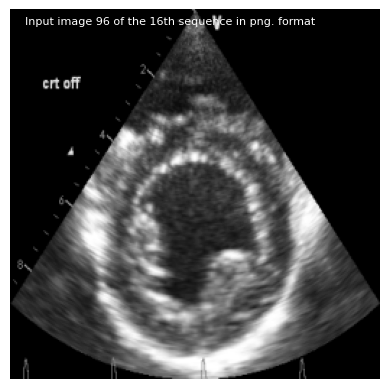

In [10]:

# Set the path to the directory containing the BMP image

# Change the current working directory
os.chdir(output_folder)

# Load the BMP image using OpenCV
image = cv2.imread('Image01145.png')

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print("Shape of the grayscale image:", gray_image.shape)

# Display the image
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.text(10, 10, 'Input image 96 of the 16th sequence in png. format', color='white', fontsize=8)
plt.show()




### Analysis 3: Segmentation Mask (with papillary muscles) Generation in all training images.

This code iterates over the set of MATLAB files containing segmentation coordinates for the training images. It extracts inner and outer contours from each file and creates corresponding binary masks. These masks are resized and saved as PNG files in an output folder. Finally, the file paths of the generated masks are stored in a DataFrame and exported to a CSV file.

In [57]:
# Define the columns for the DataFrame
cols = ['Training_Output_Mask']

# Initialize list to store file paths
file_paths = []

# Define image dimensions for resizing
width, height = 256, 256
dim = (width, height)

count = 1

for i in range(16):
    # Load the original image from MATLAB file
    mat_file = sio.loadmat(os.path.join(input_folder, f'O{i+1}.mat'))
    D = mat_file['output']
    Ditems = D['Inner_with_Papillary_Muscles']
    Ditems1 = D['Outer']

    # Iterate over each image in the original image set
    num_columns = Ditems.shape[1]  # Get the number of columns
    for j in range(num_columns):
        Cs = Ditems[0][j]
        Cs1 = Ditems1[0][j]
        inX, outX, inY, outY = [], [], [], []

        for inner_array_cs, inner_array_cs1 in zip(Cs[0], Cs1[0]):
            for element in inner_array_cs:
                ins = element[0]  # Access the first element of the nested array
                inX.append(ins)
                iy = element[1]  # Access the second element of the nested array
                inY.append(iy)

            for element in inner_array_cs1:
                ous = element[0]  # Access the first element of the nested array
                outX.append(ous)
                oy = element[1]  # Access the second element of the nested array
                outY.append(oy)

        inX, outX, inY, outY = np.array(inX), np.array(outX), np.array(inY), np.array(outY)

        contours1 = np.zeros((len(inX), 2))
        contours2 = np.zeros((len(outX), 2))

        for w in range(len(inX)):
            contours1[w] = [inX[w], inY[w]]
            contours2[w] = [outX[w], outY[w]]

        img1 = np.zeros((339, 413))  # create a single channel 200x200 pixel black image
        cv2.fillPoly(img1, np.int32([contours1]), color=(255, 255, 255))
        img2 = np.zeros((339, 413))  # create a single channel 200x200 pixel black image
        cv2.fillPoly(img2, np.int32([contours2]), color=(255, 255, 255))
        Seg = img2 - img1
        S = cv2.resize(Seg, dim, interpolation=cv2.INTER_AREA)

        # Generate file name for the resized image
        fsave = os.path.join(output_mask_folder, f'Segment{count:05}.png')

        # Save the resized image
        cv2.imwrite(fsave, S)

        # Add file path to the list
        file_paths.append(fsave)

        count += 1

# Create DataFrame from the list of file paths
dfk = pd.DataFrame({'Training_Output_Mask': file_paths})

# Save the DataFrame as a CSV file
output_csv = os.path.join(input_folder, 'Training_Output.csv')
dfk.to_csv(output_csv, index=False)


### Analysis 4: Visualization of Segmentation Mask (with papillary muscles)

**Data Loading and Extraction:**

The working directory is set to the location containing the training data for left ventricle segmentation.
It loads the last image from the O16.mat file, which corresponds to the mask for the input image in Analysis 2.
Specific data arrays related to the inner and outer boundaries of left ventricle are extracted from the loaded data.

**Data Analysis and Visualization:**

Specific data points within the extracted arrays are selected to obtain coordinates representing the inner and outer boundaries.
X and Y coordinates are extracted from the obtained data points.

**Plotting Boundaries:**

Matplotlib is utilized to create a filled area plot, representing the inner and outer boundaries of left ventricles.
Plot dimensions and background color are configured to ensure clarity and readability.
The y-axis direction is reversed to align with common image coordinate systems.
This code segment serves as a preprocessing step for left ventricle segmentation analysis, facilitating data extraction, visualization, and understanding of the dataset's structure and content.

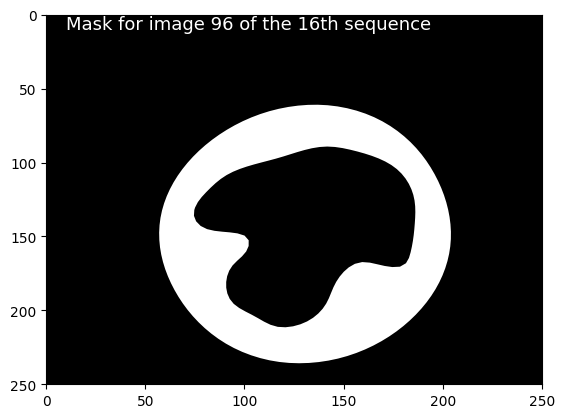

In [22]:
os.chdir(input_folder)
os.listdir()
# Load the MAT file
i = 15
file_load = 'O' + str(i + 1) + '.mat'
mat_data = sio.loadmat(file_load)

# Extract relevant data
D = mat_data['output']
Ditems = D['Inner_with_Papillary_Muscles']
Ditems1 = D['Outer']

# Select a specific image
Cs = Ditems[0, 95]
Cs1 = Ditems1[0, 95]

# Extract coordinates
inX = Cs[0, 0][:, 0]
outX = Cs1[0, 0][:, 0]
inY = Cs[0, 0][:, 1]
outY = Cs1[0, 0][:, 1]

# Set plot dimensions
w, h = 250, 250

# Plot the mask
plt.fill_between(outX, outY, 0, facecolor='white')
plt.fill_between(inX, inY, 0, facecolor='black')
plt.xlim([0, w])
plt.ylim([0, h])
plt.rcParams['axes.facecolor'] = 'black'
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.text(10, 10, 'Mask for image 96 of the 16th sequence', color='white', fontsize=13)
plt.show()

### Analysis 5: Segmentation Mask (without papillary muscles) Generation in all images.

This code iterates over a set of MATLAB files containing segmentation data. It extracts inner and outer contours from each file and creates corresponding binary masks. These masks are resized and saved as PNG files in an output folder. Finally, the file paths of the generated masks are stored in a DataFrame and exported to a CSV file.

In [6]:
# Define the columns for the DataFrame
cols = ['Training_Output_Mask']

# Create a new DataFrame object
df = pd.DataFrame(columns=cols)

# Define image dimensions for resizing
width = 256
height = 256
dim = (width, height)

# Initialize count for file naming
count = 1
# Iterate over each image file
for i in range(16):
    # Load the original image from MATLAB file
    fload = os.path.join(input_folder, 'O' + str(i+1) + '.mat')
    f = sio.loadmat(fload)
    D = f['output']
    Ditems = D['Inner_without_Papillary_Muscles']
    Ditems1 = D['Outer']
    x, y = Ditems.shape
    
    # Iterate over each image in the original image set
    for k in range(y):
        Cs = Ditems[0, k]
        Cs1 = Ditems1[0, k]
        inX = Cs[0, 0][:, 0]
        outX = Cs1[0, 0][:, 0]
        inY = Cs[0, 0][:, 1]
        outY = Cs1[0, 0][:, 1]
        
        contours1 = np.zeros((len(inX), 2))
        contours2 = np.zeros((len(inX), 2))
        
        for w in range(len(inX)):
            contours1[w] = [inX[w], inY[w]]
            contours2[w] = [outX[w], outY[w]]
        
        img1 = np.zeros((256, 256))
        cv2.fillPoly(img1, np.int32([contours1]), color=(255, 255, 255))
        img2 = np.zeros((256, 256))
        cv2.fillPoly(img2, np.int32([contours2]), color=(255, 255, 255))
        Seg = img2 - img1
        S = cv2.resize(Seg, dim, interpolation=cv2.INTER_AREA)
        
        count += 1
        fsave = os.path.join(nonpap_mask_folder, 'Segment' + str(count).zfill(5) + '.png')
        cv2.imwrite(fsave, S)
        
        # Add a new row to the DataFrame
        new_row = pd.DataFrame({'Training_Output_Mask': [fsave]})
        df = pd.concat([df, new_row], ignore_index=True)

# Save the DataFrame as a CSV file
nonpap_output_csv = os.path.join(input_folder, 'Training_Output.csv')
df.to_csv(nonpap_output_csv, index=False)


### Analysis 6: Preprocess of test input images in PNG format

The input test image data is processed, and each image is resized to a standard size of 256x256 pixels and saved as a PNG file to be used for the methodology. The code compiles a list of the saved file names into a CSV file named 'Testing_Input.csv'. 


In [47]:
cols = ['Testing_Input_File']
df = pd.DataFrame(columns=cols)

width = 256
height = 256
dim = (width, height)
count = 1

for i in range(4):
    os.chdir(test_input_path)
    fload = 'I'+str(i+1)+'.mat'
    f = sio.loadmat(fload)
    D = f['I']
    Tf = D['tframe']
    Iref = Tf[0,0]
    x, y = Iref.shape

    os.chdir(test_out_path)
    for j in range(y):
        I = Iref[0, j]
        I = np.asarray(I[0])  # Convert I to numpy array
        U = cv2.resize(I, dim, interpolation=cv2.INTER_AREA)
        fsave = 'Image' + str(count).zfill(5) + '.png'
        cv2.imwrite(fsave, U)  # Save image as PNG file
        count = count + 1

        new_row_df = pd.Series([fsave], index=cols)
        df = pd.concat([df, new_row_df], ignore_index=True)

os.chdir(test_input_path)
df.to_csv('Testing_Input.csv', index=False)


<!-- ### Analysis 7:  Segmentation Mask (with papillary muscles) Generation in test images.

In this section, the code extracts the inner and outer contours of the left ventricle from each image, generates binary segmented images, resizes them to a standard size, and saves them as PNG files. Additionally, it constructs DataFrames to store information about the saved files and their indices and saves this information into CSV files. Overall, the code prepares the input data for further analysis or evaluation by segmenting and standardizing the images. -->

### Analysis 8: Segmentation Mask (without papillary muscles) Generation in test images.


In [42]:
# Initialize DataFrame
cols = ['Test_Output_File']
df = pd.DataFrame(columns=cols)

# Set image dimensions
width = 256
height = 256
dim = (width, height)
count = 0

# Iterate over each image file
for i in range(5):
    # Load the original image from MATLAB file
    fload = os.path.join(test_input_path, 'O' + str(i+1) + '.mat')
    f = sio.loadmat(fload)
    D = f['output']
    Ditems = D['Inner_without_Papillary_Muscles']
    Ditems1 = D['Outer']
    x, y = Ditems.shape
    
    # Iterate over each image in the original image set
    for k in range(y):
        Cs = Ditems[0, k]
        Cs1 = Ditems1[0, k]
        inX = Cs[0, 0][:, 0]
        outX = Cs1[0, 0][:, 0]
        inY = Cs[0, 0][:, 1]
        outY = Cs1[0, 0][:, 1]
        
        contours1 = np.zeros((len(inX), 2))
        contours2 = np.zeros((len(inX), 2))
        
        for w in range(len(inX)):
            contours1[w] = [inX[w], inY[w]]
            contours2[w] = [outX[w], outY[w]]
        
        img1 = np.zeros((256, 256))
        cv2.fillPoly(img1, np.int32([contours1]), color=(255, 255, 255))
        img2 = np.zeros((256, 256))
        cv2.fillPoly(img2, np.int32([contours2]), color=(255, 255, 255))
        Seg = img2 - img1
        S = cv2.resize(Seg, dim, interpolation=cv2.INTER_AREA)
        
        count += 1
        fsave = os.path.join(test_nopap_output_folder, 'Segment' + str(count).zfill(5) + '.png')
        cv2.imwrite(fsave, S)
        
        # Add a new row to the DataFrame
        new_row = pd.DataFrame({'Test_Output_File': [fsave]})
        df = pd.concat([df, new_row], ignore_index=True)

# Save the DataFrame as a CSV file
output_csv = os.path.join(test_input_path, 'Test_Nopap_Output.csv')
df.to_csv(output_csv, index=False)

### Step 9: Segmentation Mask (with papillary muscles) Generation in test images.


In [51]:
# Define the columns for the DataFrame
cols = ['Test_Output_File']
colsi = ['Indices']
df = pd.DataFrame(columns=cols)
dfi = pd.DataFrame(columns=colsi)

# Define image dimensions for resizing
width = 256
height = 256
dim = (width, height)

# Initialize count for file naming
count = 0


# Iterate over each image file
for i in range(5):
    # Load the original image from MATLAB file
    fload = os.path.join(test_input_path, 'O' + str(i+1) + '.mat')
    f = sio.loadmat(fload)
    D = f['output']
    Ditems = D['Inner_with_Papillary_Muscles']
    Ditems1 = D['Outer']
    x, y = Ditems.shape

    # Iterate over each image in the original image set
    for k in range(y):
        Cs = Ditems[0, k]
        Cs1 = Ditems1[0, k]
        inX = Cs[0, 0][:, 0]
        outX = Cs1[0, 0][:, 0]
        inY = Cs[0, 0][:, 1]
        outY = Cs1[0, 0][:, 1]

        contours1 = np.zeros((len(inX), 2))
        contours2 = np.zeros((len(inX), 2))

        for w in range(len(inX)):
            contours1[w] = [inX[w], inY[w]]
            contours2[w] = [outX[w], outY[w]]

        img1 = np.zeros((256, 256))
        cv2.fillPoly(img1, np.int32([contours1]), color=(255, 255, 255))
        img2 = np.zeros((256, 256))
        cv2.fillPoly(img2, np.int32([contours2]), color=(255, 255, 255))
        Seg = img2 - img1
        S = cv2.resize(Seg, dim, interpolation=cv2.INTER_AREA)

        count += 1
        fsave = os.path.join(test_pap_output_folder, 'Segment' + str(count).zfill(5) + '.png')
        cv2.imwrite(fsave, S)

        # Add a new row to the DataFrame
        new_row = pd.DataFrame({'Test_Output_File': [fsave]})
        df = pd.concat([df, new_row], ignore_index=True)

        new_row_i = pd.DataFrame({'Indices': [count]})
        dfi = pd.concat([dfi, new_row_i], ignore_index=True)

# Save the DataFrames as CSV files
output_csv = os.path.join(test_input_path, 'test_pap_output.csv')
df.to_csv(output_csv, index=False)

output_csv_indices = os.path.join(test_input_path, 'testing_indices.csv')
dfi.to_csv(output_csv_indices, index=False)


### Inference Analysis

### References:

Awasthi, N., Vermeer, L., Fixsen, L. S., Lopata, R. G., & Pluim, J. P. (2022). LVNet: Lightweight model for left ventricle segmentation for short axis views in echocardiographic imaging. IEEE Transactions on Ultrasonics, Ferroelectrics, and Frequency Control, 69(6), 2115–2128. doi:10.1109/tuffc.2022.3169684 

Fixsen, L. S., de Lepper, A. G. W., Strik, M., van Middendorp, L. B., Prinzen, F. W., van de Vosse, F. N., … Lopata, R. G. P. (2019). Echocardiographic assessment of left bundle branch–related strain DYSSYNCHRONY: A comparison with tagged MRI. Ultrasound in Medicine &amp; Biology, 45(8), 2063–2074. doi:10.1016/j.ultrasmedbio.2019.03.012 

Strik, M., van Middendorp, L. B., Houthuizen, P., Ploux, S., van Hunnik, A., Kuiper, M., … Prinzen, F. W. (2013). Interplay of electrical wavefronts as determinant of the response to cardiac resynchronization therapy in dyssynchronous canine hearts. Circulation: Arrhythmia and Electrophysiology, 6(5), 924–931. doi:10.1161/circep.113.000753 
